In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
from scipy import stats
from keras.preprocessing import sequence
from keras.layers import  Input, Dense, Flatten, Add,\
    BatchNormalization, Concatenate, Dropout, Activation, Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.models import Model, load_model
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import keras.backend as K

Using TensorFlow backend.
/home/haoran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
from sklearn.metrics import roc_auc_score
# need to modify to work for 6 labels
class ROCCallBack(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [2]:
def flatten(x):
    if isinstance(x, (np.ndarray, list, tuple, pd.Series)):
        lst = []
        for i in x:
            lst += flatten(i)
        return lst
    else:
        return [x]

#### Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
output_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [6]:
train[output_names].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [7]:
train['tokens'] = train['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))
test['tokens'] = test['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))

In [8]:
train['tokens'].head()

0    [explanation, why, the, edits, made, under, my...
1    [d'aww, !, he, matches, this, background, colo...
2    [hey, man, ,, i, 'm, really, not, trying, to, ...
3    [``, more, i, ca, n't, make, any, real, sugges...
4    [you, ,, sir, ,, are, my, hero, ., any, chance...
Name: tokens, dtype: object

In [9]:
train['tokLength'] = train['tokens'].apply(lambda x: len(x))

In [10]:
train['tokLength'].describe()

count    159571.000000
mean         80.322201
std         120.769777
min           1.000000
25%          20.000000
50%          43.000000
75%          89.000000
max        4948.000000
Name: tokLength, dtype: float64

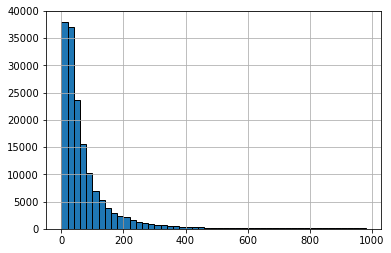

In [11]:
train['tokLength'].hist(bins = range(0, 1000, 20),linewidth = 1, edgecolor = 'black' )
plt.show()
#looks like max_length of 500 should be good

In [12]:
stats.percentileofscore(train['tokLength'].values, 500)

98.256575442906296

In [13]:
max_length = 500

What are the most common words in the texts?

In [14]:
dist = nltk.FreqDist(flatten(train.tokens.values))

In [15]:
print('Number of total tokens in the training set:', dist.N())
print('Number of unique tokens in the training set:', dist.B())

Number of total tokens in the training set: 12817094
Number of unique tokens in the training set: 259285


In [16]:
dist.most_common(n=50)

[('.', 502031),
 ('the', 495401),
 (',', 471812),
 ('to', 296851),
 ("''", 242526),
 ('i', 236559),
 ('of', 224008),
 ('and', 222709),
 ('you', 216674),
 ('a', 214116),
 ('is', 180287),
 ('that', 160512),
 ('``', 155372),
 ('it', 147625),
 ('in', 144392),
 ('!', 105576),
 ('for', 102451),
 ('this', 96943),
 ('not', 96581),
 (')', 90711),
 ('on', 89409),
 ('(', 85085),
 ('be', 83326),
 (':', 82772),
 ('as', 77269),
 ('have', 73939),
 ('are', 73404),
 ('?', 71692),
 ("'s", 66767),
 ('your', 63258),
 ('do', 62602),
 ('with', 59498),
 ('if', 58363),
 ("n't", 57137),
 ('article', 56859),
 ('was', 56537),
 ('or', 52514),
 ('but', 50938),
 ('page', 45656),
 ('my', 45520),
 ('wikipedia', 45418),
 ('an', 44513),
 ('from', 41411),
 ('by', 41040),
 ('at', 39430),
 ('can', 37244),
 ('about', 37043),
 ('me', 37025),
 ('so', 35968),
 ('what', 35291)]

#### Load GloVe

In [17]:
f = open('data/glove.42B.300d.txt', 'r', encoding = 'utf-8')

In [18]:
all_unique_tokens = set(flatten(train.tokens.values)).union(set(flatten(test.tokens.values)))

In [19]:
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    # Whole GloVe embeddings doesn't fit in my GPU memory, so only take words which appear in data for now. 
    # Can always swap weights for embedding layer after model training
    if word in all_unique_tokens:
        coefs = np.array(values[1:], dtype = 'float32')
        embeddings[word] = coefs

In [20]:
np.random.seed(10)
embeddings['<UNK>'] = np.random.normal(scale = 0.6,size = embeddings['.'].shape)

What are the most common words not in the vocab?

In [21]:
notInVocab = []
for i in dist.most_common():
    if i[0] not in embeddings.keys() and i[1]>100:
        notInVocab.append((i[0], i[1]))

In [22]:
notInVocab

[('•', 5300),
 ('==', 3145),
 ('~~~~', 1472),
 ('style=', 1303),
 ('·', 1109),
 ('|-', 868),
 ('*', 730),
 ('f5fffa', 713),
 ('..', 683),
 ('width=', 667),
 ('|style=', 635),
 ('====', 627),
 ('yourselfgo', 621),
 ('—preceding', 540),
 ('border:1px', 523),
 ('//en.wikipedia.org/w/index.php', 471),
 ("'image", 420),
 ('philippineslong', 420),
 ('cellpadding=', 372),
 ('pro-assad.hanibal911you', 345),
 ('bitches.fuck', 333),
 ('deneid', 331),
 ('rice=', 330),
 ('three-revert', 328),
 ("'fuck", 325),
 ('\u200e', 321),
 ('pagedelete', 312),
 ('|class=', 308),
 ('notrhbysouthbanof', 308),
 ('→', 307),
 ('mainpagebg', 304),
 ('//', 304),
 ('an/i', 292),
 ('admin-', 289),
 ('criminalwar', 279),
 ('bunksteve', 278),
 ('||', 269),
 ('marcolfuck', 260),
 ('boymamas', 258),
 ('penis/////small', 249),
 ("'the", 244),
 ('edgar181', 236),
 ('//en.wikipedia.org/wiki/wikipedia', 228),
 ('tommy2010', 228),
 ('securityfuck', 227),
 ('edit-warring', 224),
 ('bastered==bastered', 217),
 ('youbollocks', 21

#### Data Preparation

In [23]:
idx2word = {count:i for count, i in enumerate(embeddings.keys())}
word2idx = {idx2word[i]: i for i in idx2word.keys()}

In [24]:
print(word2idx['testing'])
print(word2idx['<UNK>'])
print(idx2word[123])

1674
211860
could


In [25]:
n_factors = 300
vocab_size = len(embeddings)

In [26]:
zero_vector_idx = vocab_size #place blank character last
idx2word[zero_vector_idx] = ''
word2idx[''] = zero_vector_idx

In [27]:
def create_emb():
    emb = np.zeros((vocab_size+1,n_factors), dtype = 'float32')
    for i in range(0, vocab_size):
        word = idx2word[i]
        emb[i,:] = embeddings[word] #each row is a word
    return emb

In [28]:
emb = create_emb()

In [29]:
emb.shape

(211862, 300)

In [30]:
# parse train/test sets
table = str.maketrans("","", string.punctuation)
def toksToInds(listToks):
    ans = []
    for count, i in enumerate(listToks):
        try:
            ans.append(word2idx[i])
        except KeyError:
            temp = i.translate(table)
            if temp and temp in word2idx.keys():
                ans.append(word2idx[temp])
            else:
                ans.append(word2idx['<UNK>'])        
    return np.array(ans)

train['idxInput'] = train['tokens'].apply(toksToInds)
test['idxInput'] = test['tokens'].apply(toksToInds)

In [31]:
train_mat = sequence.pad_sequences(train['idxInput'].values, maxlen = max_length, value = zero_vector_idx)
test_mat = sequence.pad_sequences(test['idxInput'].values, maxlen = max_length, value = zero_vector_idx)

In [32]:
train_mat.shape

(159571, 500)

In [33]:
' '.join([idx2word[i] for i in train_mat[0,:]])

"                                                                                                                                                                                                                                                                                                                                                                                                                                                                   explanation why the edits made under my username hardcore metallica fan were reverted ? they were n't vandalisms , just closure on some gas after i voted at new york dolls fac . and please do n't remove the template from the talk page since i 'm retired <UNK>"

In [34]:
# train test split
indexTrain = np.random.choice(range(train_mat.shape[0]), size = int(0.9*train_mat.shape[0]), replace = False)
indexVal = list(set(range(train_mat.shape[0])) - set(indexTrain))
dataInputTrain = train_mat[indexTrain]
dataInputVal = train_mat[indexVal]
traindf = train.loc[indexTrain]
valdf = train.loc[indexVal]

In [35]:
valdf[output_names].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,14398,15786,15102,15916,15139,15811
1,1560,172,856,42,819,147


#### Modelling

In [309]:
# simple starter
# vec_input = Input(shape = (max_length,))
# x = Embedding(vocab_size+1, n_factors, input_length=max_length,weights = [emb], trainable = False)(vec_input)
# x = Conv1D(64,7,activation = 'relu', padding = 'same')(x)
# x = MaxPooling1D(2)(x)
# # x = Dropout(0.2)(x)

# x = Conv1D(64,7,activation = 'relu', padding = 'same')(x)
# x = GlobalMaxPooling1D()(x)
# x = Dropout(0.5)(x)

# x = Dense(32, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4))(x)
# x = Dense(len(output_names), activation = 'sigmoid')(x)

# model = Model(inputs = vec_input, outputs = x)
# model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
# model.summary()

In [36]:
vec_input = Input(shape = (max_length,))
x = Embedding(vocab_size+1, n_factors, input_length=max_length,weights = [emb], trainable = False)(vec_input)
x = BatchNormalization(axis = -1)(x)
#conv 1
x = Conv1D(32, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 2
x = Conv1D(64, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 3
x = Conv1D(64, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 4
x = Conv1D(128, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

# #conv 5
# x = Conv1D(128, 7, activation = 'relu', padding = 'same')(x)
# x = BatchNormalization(axis = -1)(x)
# x = MaxPooling1D(pool_size = 2)(x)
# x = Dropout(0.2)(x)

#dense 1
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.4)(x)

#dense 2
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
#x = Dropout(0.4)(x)

In [37]:
# add output layers
outputs = []
for i in output_names:
    intermediate_act = Dense(units = 128, activation = 'relu')(x)
    intermediate_act = BatchNormalization(axis = -1)(intermediate_act)
    if i in ['toxic','obscene']:
        intermediate_act = Dense(units = 256, activation = 'relu')(intermediate_act)
        intermediate_act = BatchNormalization(axis = -1)(intermediate_act)
    outputs.append(Dense(units = 1, activation = 'sigmoid', name = i)(intermediate_act))

In [38]:
model = Model(inputs = vec_input, outputs = outputs)

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     63558600    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 500, 300)     1200        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 32)      67232       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [41]:
model.compile(Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [42]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('weights/cnn_mdl', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
tensor_board = TensorBoard(log_dir='./logs/run1', write_graph = False,)
#roc_callback = ROCCallBack(training_data = [dataInputTrain, ])

In [43]:
K.set_value(model.optimizer.lr, 1e-3)
model.fit(x = dataInputTrain, 
          y = [traindf[i] for i in output_names],
         batch_size = 64, epochs = 200, validation_data = [dataInputVal, [valdf[i] for i in output_names]],
         callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tensor_board])

Train on 143613 samples, validate on 15958 samples
Epoch 1/200
143613/143613 [==============================] - 195s 1ms/step - loss: 0.5414 - toxic_loss: 0.1571 - severe_toxic_loss: 0.0595 - obscene_loss: 0.1040 - threat_loss: 0.0445 - insult_loss: 0.1134 - identity_hate_loss: 0.0629 - toxic_acc: 0.9409 - severe_toxic_acc: 0.9813 - obscene_acc: 0.9609 - threat_acc: 0.9891 - insult_acc: 0.9551 - identity_hate_acc: 0.9826 - val_loss: 0.3352 - val_toxic_loss: 0.1040 - val_severe_toxic_loss: 0.0375 - val_obscene_loss: 0.0725 - val_threat_loss: 0.0147 - val_insult_loss: 0.0721 - val_identity_hate_loss: 0.0343 - val_toxic_acc: 0.9632 - val_severe_toxic_acc: 0.9892 - val_obscene_acc: 0.9653 - val_threat_acc: 0.9974 - val_insult_acc: 0.9672 - val_identity_hate_acc: 0.9897
Epoch 2/200
143613/143613 [==============================] - 187s 1ms/step - loss: 0.3269 - toxic_loss: 0.1107 - severe_toxic_loss: 0.0276 - obscene_loss: 0.0652 - threat_loss: 0.0165 - insult_loss: 0.0737 - identity_hate_lo

#### Pseudo Labelling

In [401]:
model = load_model('weights/cnn_mdl')

ResourceExhaustedError: OOM when allocating tensor with shape[211862,300]
	 [[Node: embedding_5_5/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_5_5/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_5_5/embeddings, embedding_5_5/random_uniform)]]

Caused by op 'embedding_5_5/embeddings/Assign', defined at:
  File "/home/haoran/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/haoran/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-401-dc1e8f026964>", line 1, in <module>
    model = load_model('weights/cnn_mdl')
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/models.py", line 240, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/models.py", line 314, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 2500, in from_config
    process_node(layer, node_data)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 2457, in process_node
    layer(input_tensors[0], **kwargs)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/layers/embeddings.py", line 101, in build
    dtype=self.dtype)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 400, in add_weight
    constraint=constraint)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 380, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 346, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 57, in assign
    use_locking=use_locking, name=name)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/haoran/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[211862,300]
	 [[Node: embedding_5_5/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_5_5/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_5_5/embeddings, embedding_5_5/random_uniform)]]


In [395]:
K.set_value(model.optimizer.lr, 1e-3)
model.fit(x = dataInputTrain, 
          y = [traindf[i] for i in output_names],
         batch_size = 64, epochs = 1, validation_data = [dataInputVal, [valdf[i] for i in output_names]],)

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 184s 1ms/step - loss: 0.3083 - toxic_loss: 0.1049 - severe_toxic_loss: 0.0256 - obscene_loss: 0.0595 - threat_loss: 0.0153 - insult_loss: 0.0707 - identity_hate_loss: 0.0324 - toxic_acc: 0.9609 - severe_toxic_acc: 0.9898 - obscene_acc: 0.9765 - threat_acc: 0.9970 - insult_acc: 0.9699 - identity_hate_acc: 0.9912 - val_loss: 0.3146 - val_toxic_loss: 0.1044 - val_severe_toxic_loss: 0.0264 - val_obscene_loss: 0.0613 - val_threat_loss: 0.0136 - val_insult_loss: 0.0764 - val_identity_hate_loss: 0.0326 - val_toxic_acc: 0.9581 - val_severe_toxic_acc: 0.9893 - val_obscene_acc: 0.9765 - val_threat_acc: 0.9974 - val_insult_acc: 0.9659 - val_identity_hate_acc: 0.9908


In [ ]:
model.evaluate(x = dataInputVal, y = [valdf[i] for i in output_names])

In [362]:
pred_unlabeled = model.predict(test_mat)

In [363]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')

In [386]:
def shuffleTogether(X, Y):
    p = np.random.permutation(X.shape[0])
    return X[p,:], [i[p] for i in Y]        

In [390]:
#add test data such that it's about 1/3 of the training set
def createPseudoGenerator( XTrain, XTest, YTrain, YTest):
    while True:
        idxTest = np.random.permutation( XTest.shape[0])[:int((1/2.0)*XTrain.shape[0])]        
        idx = np.random.permutation( XTrain.shape[0])
        X = np.vstack((XTrain[idx], XTest[idxTest]))
        Y = []
        for i in range(len(YTrain)):
            Y.append(np.concatenate((YTrain[i][idx], YTest[i][idxTest].flatten())))
        #X,Y = shuffleTogether(X,Y)
        idx0 = 0
        batch_size = 64
        while True:           
            idx1 = idx0 + batch_size
            yield X[idx0:idx1 ], [i[idx0:idx1] for i in Y]
            idx0 = idx1
            if idx1 >= X.shape[0]:
                break

In [391]:
K.set_value(model.optimizer.lr, 5e-3)
model.fit_generator(createPseudoGenerator(XTrain = dataInputTrain, XTest = test_mat, 
                                          YTrain = [traindf[i] for i in output_names],
                                         YTest = pred_unlabeled) ,
         validation_data = [dataInputVal, [valdf[i] for i in output_names]],
         callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tensor_board],
         steps_per_epoch = (1.5*len(traindf))//64+1 )

Epoch 1/1
  94/3366 [..............................] - ETA: 5:53 - loss: nan - toxic_loss: nan - severe_toxic_loss: nan - obscene_loss: nan - threat_loss: nan - insult_loss: nan - identity_hate_loss: nan - toxic_acc: 0.0080 - severe_toxic_acc: 0.0095 - obscene_acc: 0.0085 - threat_acc: 0.0096 - insult_acc: 0.0086 - identity_hate_acc: 0.0095

KeyboardInterrupt: 

Examining what the model got wrong

In [ ]:
pred_val = model.predict(dataInputVal)

In [332]:
# for count,i in enumerate(output_names):
#     print('---------------' + i + '---------------------')
#     dif = (valdf[i] - pred_val[count].flatten()).abs().sort_values(ascending = False)
#     most_dif = valdf.loc[dif.index[:2]]
#     for count2, j in enumerate(most_dif.iterrows()):
#         print('Predicted', pred_val[count].flatten()[valdf[i].index.get_loc(j[0])]
#               , 'Actual', j[1][i],
#              '\n',
#              j[1]['comment_text'])

#### Submission

In [397]:
pred = model.predict(test_mat)

In [398]:
for count,i in enumerate(output_names):
    test[i] = pred[count].flatten()

In [399]:
test[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv('data/answers/basic_baseline_cnn.csv', index = False)